In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tensorflow as tf


# Gaussian Sample Generation

In [2]:
def gaussian(mean, std, num_sample):
    ret = np.random.normal(mean, std, num_sample)
    return ret

In [3]:
mean = 0
std = 1
num_sample = 1000
gaussian_dist = gaussian(mean,std,num_sample)

In [4]:
count, bins, ignored = plt.hist(gaussian_dist, 30, normed=True)
plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (bins - mean)**2 / (2 * std**2) ),linewidth=2, color='r')


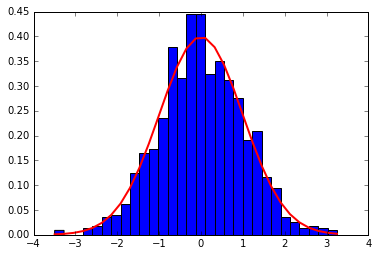

In [5]:
plt.show()

# Bivariate Gaussian sample generation

In [6]:
def multigaussian(mean, cov, num_sample):
    u = mean
    v = cov
    
    value,vector=np.linalg.eig(cov)

        
    U = vector
    Lambda = np.array([[value[0],0],[0,value[1]]])
    Lambda_sqrt = np.sqrt(Lambda)
    At = np.matmul(U , Lambda_sqrt)
    A = np.matmul(Lambda_sqrt,np.linalg.inv(U))

    gaussian_x = gaussian(0,1,num_sample)
    gaussian_y = gaussian(0,1,num_sample)
    gaussian_xy = []
    for i in range(num_sample):
        xy = [gaussian_x[i],gaussian_y[i]]
        gaussian_xy.append(xy)
    gaussian_xy = np.array(gaussian_xy) #(30,2)
    gaussian_xy = np.transpose(gaussian_xy) #(2,30)

    y = np.matmul(At, gaussian_xy) #(2,2) (2,30)
    for i in range(num_sample):
        y[0][i] = y[0][i] + u[0]
        y[1][i] = y[1][i] + u[1]
      
    return np.transpose(y)
    

In [7]:
mean1 = np.array([3,3])#.reshape([2,1])
mean2 = np.array([-4,-4])#.reshape([2,1])
mean3 = np.array([10,0])#.reshape([2,1])


In [8]:
std1 = np.array([[3,1],[1,3]])
std2 = np.array([[8,1],[1,1]])
std3 = np.array([[36,0],[0,36]])
total = 100
alpha1 = 0.3
alpha2 = 0.2
alpha3 = 0.5


In [9]:
set1 = multigaussian(mean1,std1,int(total*alpha1))
set2 = multigaussian(mean2,std2,int(total*alpha2))
set3 = multigaussian(mean3,std3,int(total*alpha3))


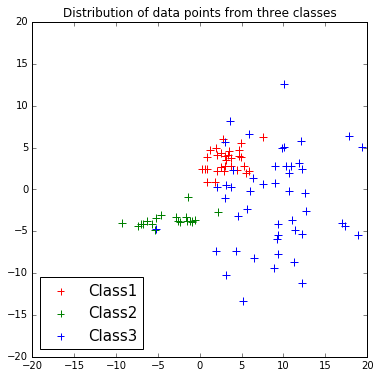

In [10]:
fig = plt.figure(figsize=(6,6)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')

group1 = ax.scatter(set1[:,0], set1[:,1],c='r', marker='+', s=50)
group2 = ax.scatter(set2[:,0], set2[:,1],c='g', marker='+', s=50)
group3 = ax.scatter(set3[:,0], set3[:,1],c='b', marker='+', s=50)

ax.set_xlim((-20,20))
ax.set_ylim((-20,20))

plt.title("Distribution of data points from three classes")
ax.legend((group1, group2, group3),
           ('Class1', 'Class2', 'Class3'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=15)
    
plt.show()

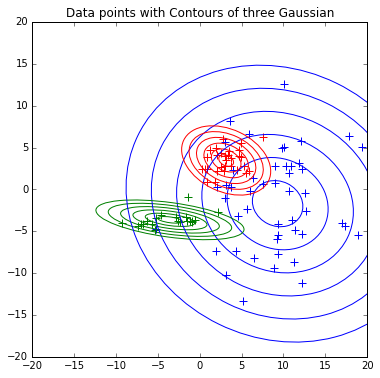

In [11]:
fig = plt.figure(figsize=(6,6)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')

group1 = ax.scatter(set1[:,0], set1[:,1],c='r', marker='+', s=50)
group2 = ax.scatter(set2[:,0], set2[:,1],c='g', marker='+', s=50)
group3 = ax.scatter(set3[:,0], set3[:,1],c='b', marker='+', s=50)

ax.set_xlim((-20,20))
ax.set_ylim((-20,20))

plt.title("Data points with Contours of three Gaussian")

cov1 = np.cov(set1[:,0], set1[:,1])
cov2 = np.cov(set2[:,0], set2[:,1])
cov3 = np.cov(set3[:,0], set3[:,1])

# MUST CHECK THIS PART COMPARED WITH UPPER FUCTION multigaussian AND LOWER k-means
lambda1_, v1 = np.linalg.eig(cov1)
lambda1_ = np.sqrt(lambda1_)

lambda2_, v2 = np.linalg.eig(cov2)
lambda2_ = np.sqrt(lambda2_)

lambda3_, v3 = np.linalg.eig(cov3)
lambda3_ = np.sqrt(lambda3_)  

def get_ell_angle(eigenvalue, eigenvector):
    high_idx = np.argmax(eigenvalue)
    highest_vector = eigenvector[high_idx]
    
    return np.arctan2(highest_vector[1], highest_vector[0])
    
for j in xrange(1, 7):
    ell1 = Ellipse(xy=(np.mean(set1[:,0]), np.mean(set1[:,1])),
                  width=lambda1_[0]*j, height=lambda1_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda1_, v1)),color='r') 
    ell2 = Ellipse(xy=(np.mean(set2[:,0]), np.mean(set2[:,1])),
                  width=lambda2_[0]*j, height=lambda2_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda2_, v2)),color='g')
    ell3 = Ellipse(xy=(np.mean(set3[:,0]), np.mean(set3[:,1])),
                  width=lambda3_[0]*j, height=lambda3_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda3_, v3)),color='b')
    
    ell1.set_facecolor('none')
    ell2.set_facecolor('none')
    ell3.set_facecolor('none')

    ax.add_artist(ell1)
    ax.add_artist(ell2)
    ax.add_artist(ell3)
    
plt.show()

# Bayesian Decision Boundary

# Neural Network (w/o hidden layer)

In [12]:
# refernce : https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [13]:
NUM_LABEL = 3
dataX = np.concatenate([set1, set2,set3], axis=0)
dataY = []

# one-hot encoding
for i in range(0, len(set1)):
    temp = np.zeros(NUM_LABEL)
    temp[0] = 1
    dataY.append(temp)
for i in range(0, len(set2)):
    temp = np.zeros(NUM_LABEL)
    temp[1] = 1
    dataY.append(temp)
for i in range(0, len(set3)):
    temp = np.zeros(NUM_LABEL)
    temp[2] = 1
    dataY.append(temp)

dataY = np.array(dataY)

dataX,dataY=unison_shuffled_copies(dataX,dataY)

(0, 2.5720024)
(200, 0.38216829)
(400, 0.37148404)
(600, 0.36522195)
(800, 0.36225116)
(1000, 0.36107683)
(1200, 0.36065817)
(1400, 0.36051506)
(1600, 0.36046684)
(1800, 0.3604506)
('Prediction:', array([0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 2, 0, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1,
       0, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2,
       1, 2, 2, 2, 0, 2, 0, 0]))
('Accuracy: ', 0.89000005)


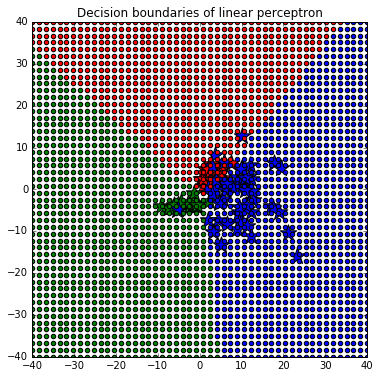

In [14]:
import tensorflow as tf

'''
trainX = []
trainY = []
testX = []
testy = []

train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])
'''
X = tf.placeholder(tf.float32, [None, 2])
Y = tf.placeholder(tf.float32, [None, NUM_LABEL])
W = tf.Variable(tf.random_normal([2, NUM_LABEL]), name='weight')
b = tf.Variable(tf.random_normal([NUM_LABEL]), name='bias')

hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

prediction = tf.arg_max(hypothesis, 1)
is_correct = tf.equal(prediction, tf.arg_max(dataY, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#reference : https://docs.google.com/presentation/d/1cVwqMpERToATs1JGYps0F3MLARP8OAlw6ZIe-lpPHYs/edit#slide=id.g1b2fb7758e_0_247
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(2000):
        sess.run(optimizer, feed_dict={X: dataX, Y: dataY})
        if step % 200 == 0:
            print(step, sess.run(cost, feed_dict={X: dataX, Y: dataY}))

    print("Prediction:", sess.run(prediction, feed_dict={X: dataX}))
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: dataX, Y: dataY}))


    # Visualize classification boundary
    # refernce : https://stackoverflow.com/questions/35666835/tensorflow-plotting-a-graph-that-describes-data-points-and-decision-boundary
    xs = np.linspace(-40, 40)
    ys = np.linspace(-40, 40)
    pred_classes = []
    for x in xs:
        for y in ys:
            pred_class = sess.run(hypothesis, feed_dict={X:[[x,y]]})
            pred_classes.append((x, y, pred_class.argmax()))
    xs_set1, ys_set1 = [], []
    xs_set2, ys_set2 = [], []
    xs_set3, ys_set3 = [], []
    for x, y, c in pred_classes:
        if c == 0:
            xs_set1.append(x)
            ys_set1.append(y)
        elif c == 1:
            xs_set2.append(x)
            ys_set2.append(y)
        elif c == 2:
            xs_set3.append(x)
            ys_set3.append(y)

    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')

    group1 = ax.scatter(set1[:,0], set1[:,1],c='r', marker='*', s=300)
    group2 = ax.scatter(set2[:,0], set2[:,1],c='g', marker='*', s=300)
    group3 = ax.scatter(set3[:,0], set3[:,1],c='b', marker='*', s=300)
    group4 = ax.scatter(xs_set1, ys_set1,c='r', marker='o', s=20)
    group5 = ax.scatter(xs_set2, ys_set2,c='g', marker='o', s=20)
    group6 = ax.scatter(xs_set3, ys_set3,c='b', marker='o', s=20)

    ax.set_xlim((-40,40))
    ax.set_ylim((-40,40))
    plt.title("Decision boundaries of linear perceptron")

    plt.show()


# Neural Network (w/2 hidden layers)

(0, 1.7524531)
(2000, 0.65656519)
(4000, 0.58276606)
(6000, 0.44754779)
(8000, 0.3527782)
(10000, 0.33616108)
(12000, 0.32511848)
(14000, 0.31553665)
(16000, 0.30972821)
(18000, 0.30592129)
('Prediction:', array([0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1,
       0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2,
       1, 2, 2, 2, 0, 2, 0, 0]))
('Accuracy: ', 0.88999999)


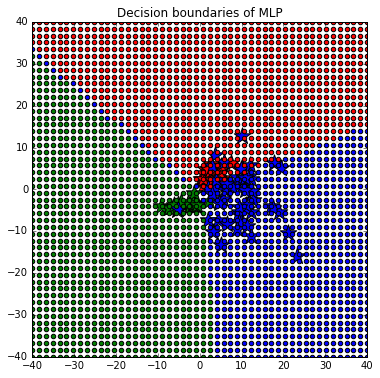

In [15]:
import tensorflow as tf


NUM_NODES = 5
X = tf.placeholder(tf.float32, [None, 2])
Y = tf.placeholder(tf.float32, [None, NUM_LABEL])

W1 = tf.Variable(tf.random_normal([2, NUM_NODES]), name='weight1')
b1 = tf.Variable(tf.random_normal([NUM_NODES]), name='bias1')
L1 = tf.nn.softmax(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([NUM_NODES, NUM_LABEL]), name='weight2')
b2 = tf.Variable(tf.random_normal([NUM_LABEL]), name='bias2')

hypothesis = tf.nn.softmax(tf.matmul(L1, W2) + b2)
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

prediction = tf.arg_max(hypothesis, 1)
is_correct = tf.equal(prediction, tf.arg_max(dataY, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

with tf.Session() as sess:
    with tf.device("/gpu:1"):

        sess.run(tf.global_variables_initializer())

        for step in range(20000):
            sess.run(optimizer, feed_dict={X: dataX, Y: dataY})
            if step % 2000 == 0:
                print(step, sess.run(cost, feed_dict={X: dataX, Y: dataY}))

        print("Prediction:", sess.run(prediction, feed_dict={X: dataX}))
        print("Accuracy: ", sess.run(accuracy, feed_dict={X: dataX, Y: dataY}))

        # Visualize classification boundary
        # refernce : https://stackoverflow.com/questions/35666835/tensorflow-plotting-a-graph-that-describes-data-points-and-decision-boundary
        xs = np.linspace(-40, 40)
        ys = np.linspace(-40, 40)
        pred_classes = []
        for x in xs:
            for y in ys:
                pred_class = sess.run(hypothesis, feed_dict={X:[[x,y]]})
                pred_classes.append((x, y, pred_class.argmax()))
        xs_set1, ys_set1 = [], []
        xs_set2, ys_set2 = [], []
        xs_set3, ys_set3 = [], []
        for x, y, c in pred_classes:
            if c == 0:
                xs_set1.append(x)
                ys_set1.append(y)
            elif c == 1:
                xs_set2.append(x)
                ys_set2.append(y)
            elif c == 2:
                xs_set3.append(x)
                ys_set3.append(y)

        fig = plt.figure(figsize=(6,6)) # default is (8,6)
        ax = fig.add_subplot(111, aspect='equal')

        group1 = ax.scatter(set1[:,0], set1[:,1],c='r', marker='*', s=300)
        group2 = ax.scatter(set2[:,0], set2[:,1],c='g', marker='*', s=300)
        group3 = ax.scatter(set3[:,0], set3[:,1],c='b', marker='*', s=300)
        group4 = ax.scatter(xs_set1, ys_set1,c='r', marker='o', s=20)
        group5 = ax.scatter(xs_set2, ys_set2,c='g', marker='o', s=20)
        group6 = ax.scatter(xs_set3, ys_set3,c='b', marker='o', s=20)

        ax.set_xlim((-40,40))
        ax.set_ylim((-40,40))
        plt.title("Decision boundaries of MLP")

        plt.show()


# Clustering

In [16]:
# reference : https://glowingpython.blogspot.kr/2012/04/k-means-clustering-with-scipy.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html#scipy.cluster.vq.vq
from scipy.cluster.vq import kmeans,vq

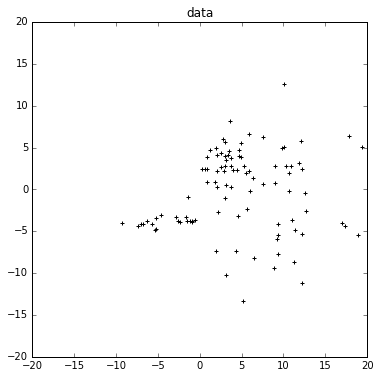

In [17]:
dataX = np.concatenate([set1, set2,set3], axis=0)

fig = plt.figure(figsize=(6,6)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((-20,20))
ax.set_ylim((-20,20))
ax.scatter(dataX[:,0],dataX[:,1],c='k', marker='+', s=20)

plt.title("data")
plt.show()



In [18]:
centroids,_ = kmeans(dataX,3,iter=10) # makes codebook by kmeans
idx,_ = vq(dataX,centroids) #observation, codebook

f, (ax1, ax2) = plt.subplots(1, 2,  sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(12)
ax1.set_xlim((-20,20))
ax1.set_ylim((-20,20))
ax2.set_xlim((-20,20))
ax2.set_ylim((-20,20))

ax1.set_title("assignment")
ax1.plot(dataX[idx==0,0],dataX[idx==0,1],'b+',
     dataX[idx==1,0],dataX[idx==1,1],'r+',
     dataX[idx==2,0],dataX[idx==2,1],'g+') # third cluster points
ax1.plot(centroids[:,0],centroids[:,1],'ko',markersize=8)



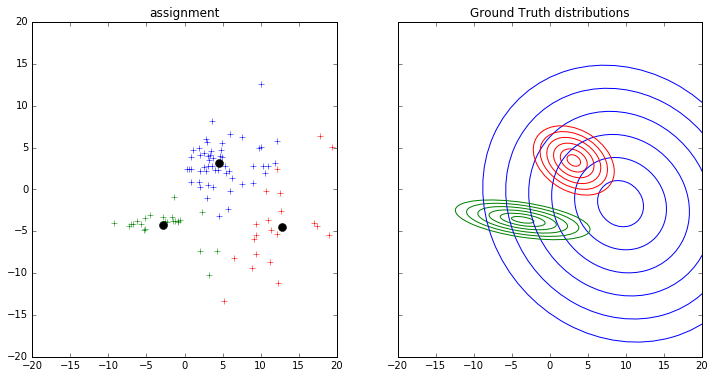

In [19]:

cov1 = np.cov(set1[:,0], set1[:,1])
cov2 = np.cov(set2[:,0], set2[:,1])
cov3 = np.cov(set3[:,0], set3[:,1])

lambda1_, v1 = np.linalg.eig(cov1)
lambda1_ = np.sqrt(lambda1_)

lambda2_, v2 = np.linalg.eig(cov2)
lambda2_ = np.sqrt(lambda2_)

lambda3_, v3 = np.linalg.eig(cov3)
lambda3_ = np.sqrt(lambda3_)  
for j in xrange(1, 7):
    ell1 = Ellipse(xy=(np.mean(set1[:,0]), np.mean(set1[:,1])),
                  width=lambda1_[0]*j, height=lambda1_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda1_, v1)),color='r') 
    ell2 = Ellipse(xy=(np.mean(set2[:,0]), np.mean(set2[:,1])),
                  width=lambda2_[0]*j, height=lambda2_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda2_, v2)),color='g')
    ell3 = Ellipse(xy=(np.mean(set3[:,0]), np.mean(set3[:,1])),
                  width=lambda3_[0]*j, height=lambda3_[1]*j,
                  angle=np.rad2deg(get_ell_angle(lambda3_, v3)),color='b')
    
    ell1.set_facecolor('none')
    ell2.set_facecolor('none')
    ell3.set_facecolor('none')

    ax2.set_title("Ground Truth distributions")
    ax2.add_artist(ell1)
    ax2.add_artist(ell2)
    ax2.add_artist(ell3)
    
plt.show()

# PCA

[[ 42.79833294  -0.88180053]
 [ -0.88180053  26.16782329]]
(2, 100)


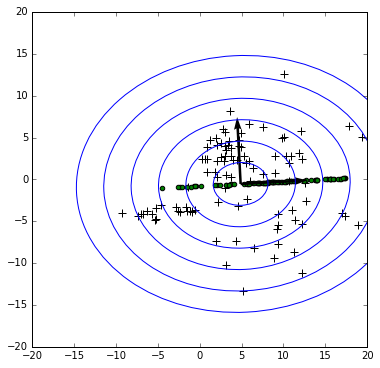

In [20]:
def proj(v, p):
    #print np.shape(vector), np.shape(point)
    #print v.reshape(1,2), p
    return np.matmul(v.reshape(1,2), p)

#cov_mat = np.cov(dataX[:,0], dataX[:,1])
cov_mat = np.cov(dataX.transpose())

value,vector=np.linalg.eig(cov_mat)

print cov_mat
meanX = np.mean(dataX[:,0])
meanY = np.mean(dataX[:,1])

high_idx = np.argmax(value)
low_idx = np.argmin(value)
highest_vector = vector[high_idx]
highest_vector_mag = np.sqrt(highest_vector[0]**2 + highest_vector[1]**2)
highest_value = value[high_idx]
low_vector = vector[low_idx]
#order
#U = [highest_vector.reshape(2,1), vector[low_idx].reshape(2,1)]
#U = [[ 0.99409328, 0.10852904], [ 0,  0]]

U = vector.transpose()

x_rot = np.matmul(U.transpose(), dataX.transpose())

'''
x_wave = []
for i in range(len(dataX)):
    x_wave.append(proj(U[0].transpose(), dataX[i]))
x_wave = np.array(x_wave)
'''
x_wave = [x_rot[0] , np.zeros(len(x_rot[0]))]


'''
x_hat = []
for i in range(len(x_wave)):
    x_hat.append(U[0].transpose() * x_wave[i])
x_hat = np.array(x_hat)
'''

x_hat = np.matmul(U, x_wave)
print np.shape(x_hat)
fig = plt.figure(figsize=(6,6)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.scatter([dataX[:,0]], dataX[:,1],c='k', marker='+', s=50) #real
#ax.scatter(x_wave[0]-meanX,x_wave[1], c='g') # proj
ax.scatter(x_hat[0]+meanX,x_hat[1]+meanY, c='g') # proj

'''
result2 = []
for i in range(len(dataX)):
    result2.append(proj(vector[0],[0,result[i]]));
    
ax.scatter(np.array(result2) + meanX, np.array(result2) + meanY, c='g') # proj
'''
lambda_ = np.sqrt(value)
for j in xrange(1, 7):
    ell = Ellipse(xy=(np.mean(dataX[:,0]), np.mean(dataX[:,1])),
                  width=lambda_[0]*j, height=lambda_[1]*j,
                  angle=np.rad2deg(np.arctan2(highest_vector[1],highest_vector[0])),color='b')
    
    ell.set_facecolor('none')
    ax.add_artist(ell)    



q = ax.quiver((meanX, meanX), (meanY, meanY),
           (vector[0][0],vector[1][0]), (vector[0][1], vector[1][1]), scale = 5)


plt.show()

# GMM

확률 밀도함수 https://ko.wikipedia.org/wiki/%ED%99%95%EB%A5%A0_%EB%B0%80%EB%8F%84_%ED%95%A8%EC%88%98
f(x)와 구간 [a,b]에 대해서 확률 변수 X가 구간에 포함될 확률 

In [21]:
import operator

#init params
param = {
        'mu1': [10,10],'sig1': [[1, 0], [0, 1]],
        'mu2': [3,3],'sig2': [[1, 0], [0, 1]],
        'mu3': [5,5],'sig3': [[1, 0], [0, 1]],
        'lambda': [0,4, 0.2, 0.4]
}

x = dataX[:,0]
y = dataX[:,1]
label = np.zeros(len(x))

data = zip(x,y,label)
data = np.array(data)

def normpdf(x, mu, sigma):
    u = (x-mu)/abs(sigma)
    y = (1/(np.sqrt(2*np.pi)*abs(sigma)))*np.exp(-u*u/2)
    return y

# prob
def prob(val, mu, sig, lam):
    p = lam
    for i in range(len(val)):
        p *= normpdf(val[i], mu[i], sig[i][i])
    return p

In [22]:
# E
def expectation(data, param):
    for i in range(len(data)):
        x = data[:,0][i]
        y = data[:,1][i]
        label = data[:,2][i]
        #print x, y, label
        cluster1 = prob([x, y], list(param['mu1']), list(param['sig1']), param['lambda'][0] )
        cluster2 = prob([x, y], list(param['mu2']), list(param['sig2']), param['lambda'][1] )
        cluster3 = prob([x, y], list(param['mu3']), list(param['sig3']), param['lambda'][2] ) 
        
        clusters = {0:cluster1, 1:cluster2, 2:cluster3}
        sorted_clusters = sorted(clusters.items(), key=operator.itemgetter(1)) #small to big
        data[:,2][i] = sorted_clusters[2][0]
        
    return data


In [23]:
# M
def maximization(data, params):
    points_cluster1 = np.array([(point[0],point[1]) for point in data if point[2] == 0])
    points_cluster2 = np.array([(point[0],point[1]) for point in data if point[2] == 1])
    points_cluster3 = np.array([(point[0],point[1]) for point in data if point[2] == 2])
    p_cluster1 = len(points_cluster1) / float(len(data))
    p_cluster2 = len(points_cluster2) / float(len(data))
    p_cluster3 = len(points_cluster3) / float(len(data))
    
    print(len(points_cluster1),len(points_cluster2),len(points_cluster3) )

    #print points_cluster1,points_cluster2,points_cluster3
    
    params['lambda'] = [p_cluster1, p_cluster2,p_cluster3 ]
    params['mu1'] = [np.mean(points_cluster1, axis=1)[0], np.mean(points_cluster1, axis=1)[1]]
    params['mu2'] = [np.mean(points_cluster2, axis=1)[0], np.mean(points_cluster2, axis=1)[1]]
    params['mu3'] = [np.mean(points_cluster3, axis=1)[0], np.mean(points_cluster3, axis=1)[1]]
    params['sig1'] = [[np.std(points_cluster1, axis=1)[0],0], [0,np.std(points_cluster1, axis=1)[1]]]
    params['sig2'] = [[np.std(points_cluster2, axis=1)[0],0], [0,np.std(points_cluster2, axis=1)[1]]]
    params['sig3'] = [[np.std(points_cluster3, axis=1)[0],0], [0,np.std(points_cluster3, axis=1)[1]]]
    return params


In [24]:
def distance(old_params, new_params):
    dist = 0
    for p in ['mu1', 'mu2', 'mu3']:
        for i in range(len(old_params[p])):
            dist += (old_params[p][i] - new_params[p][i]) ** 2
    return dist ** 0.5

In [25]:
shift = 0xFFFFFFFF
epsilon = 0.0001
iters = 0
while shift > epsilon:
    iters += 1
  # E-step
    new_labeled_data = expectation(data.copy(), param)
    
  # M-step
    new_param = maximization(new_labeled_data, param.copy())

    # see if our estimates of mu have changed
    # could incorporate all params, or overall log-likelihood
    shift = distance(param, new_param)

    old_mu = [param['mu1'],param['mu2'],param['mu3']]
    new_mu = [param['mu1'],param['mu2'],param['mu3']]

    # logging
    print("iteration {}, shift {}".format(iters, shift))

    # update labels and params for the next iteration
    data = new_labeled_data
    param = new_param
    print new_param
    x = data[:,0]
    y = data[:,1]                                                                                   
    label = data[:,2]
    fig = plt.figure()
    plt.scatter(x, y, 24, c=label)
    fig.savefig("iteration{}.png".format(iters))

(0, 76, 24)


IndexError: tuple index out of range

# Whitening

In [26]:
#whitening 1

f, (ax1, ax2) = plt.subplots(1, 2,  sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(12)

group1 = ax1.scatter(set1[:,0], set1[:,1],c='r', marker='+', s=50)
group2 = ax1.scatter(set2[:,0], set2[:,1],c='g', marker='+', s=50)
group3 = ax1.scatter(set3[:,0], set3[:,1],c='b', marker='+', s=50)

ax1.set_xlim((-20,20))
ax1.set_ylim((-20,20))

ax1.set_title("Distribution of data points from three classes")
ax1.legend((group1, group2, group3),
           ('Class1', 'Class2', 'Class3'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=15)


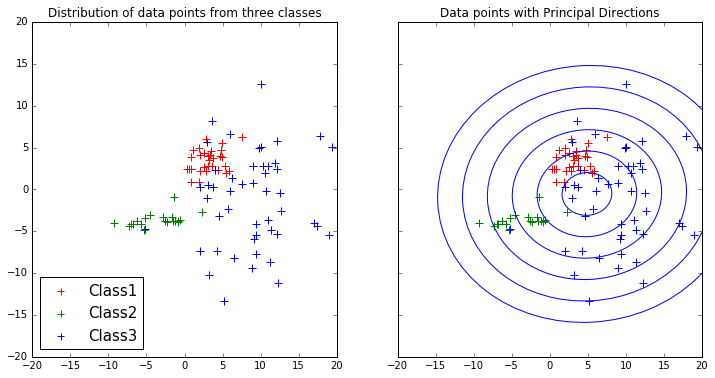

In [27]:
#whitening 2
dataX = np.concatenate([set1, set2,set3], axis=0)
cov_mat = np.cov(dataX.transpose())

value,vector=np.linalg.eig(cov_mat)
meanX = np.mean(dataX[:,0])
meanY = np.mean(dataX[:,1])

high_idx = np.argmax(value)
low_idx = np.argmin(value)
highest_vector = vector[high_idx]
highest_vector_mag = np.sqrt(highest_vector[0]**2 + highest_vector[1]**2)
highest_value = value[high_idx]
low_vector = vector[low_idx]

ax2.set_xlim(-20,20)
ax2.set_ylim(-20,20)
group1 = ax2.scatter(set1[:,0], set1[:,1],c='r', marker='+', s=50)
group2 = ax2.scatter(set2[:,0], set2[:,1],c='g', marker='+', s=50)
group3 = ax2.scatter(set3[:,0], set3[:,1],c='b', marker='+', s=50)
lambda_ = np.sqrt(value)
for j in xrange(1, 7):
    ell = Ellipse(xy=(np.mean(dataX[:,0]), np.mean(dataX[:,1])),
                  width=lambda_[0]*j, height=lambda_[1]*j,
                  angle=np.rad2deg(np.arctan2(highest_vector[1],highest_vector[0])),color='b')
    
    ell.set_facecolor('none')
    ax2.add_artist(ell)
ax2.set_title("Data points with Principal Directions")

plt.show()    

In [28]:
#whitening 3

def whitening(data):
    u = np.mean(data.transpose())
    cov = np.cov(data.transpose())
    
    value,vector=np.linalg.eig(cov)

    U = vector
    Lambda = np.array([[value[0],0],[0,value[1]]])
    Lambda_sqrt = np.sqrt(Lambda)
    Lambda_sqrt_inv = np.linalg.inv(Lambda_sqrt)
    At = np.matmul(U , Lambda_sqrt)
    A = np.matmul(Lambda_sqrt,U.transpose())
    
    a =  np.matmul(Lambda_sqrt_inv,U.transpose())
    y = np.matmul(a, data.transpose()) #(2,2) (2,30)
    #y = np.matmul(A, data.transpose()) #(2,2) (2,100)
    #y = np.matmul(np.sqrt(cov),y)
    #print np.matmul(At, cov, A)
    y = y-np.mean(y)

    
    return np.transpose(y)
    

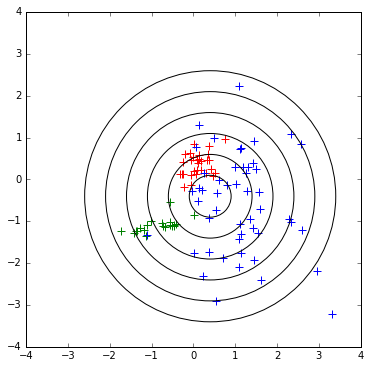

In [35]:
#whitening 4

y = whitening(dataX)

value,vector=np.linalg.eig(np.cov(y.transpose()))
high_idx = np.argmax(value)
highest_vector = vector[high_idx]

lambda_ = np.sqrt(value)

fig = plt.figure(figsize=(6,6)) # default is (8,6)
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

whitening_set1 = np.array([y[:,0][0:len(set1)], y[:,1][0:len(set1)]])
whitening_set2 = np.array([y[:,0][len(set1):len(set2)+len(set1)], y[:,1][len(set1):len(set2)+len(set1)]])
whitening_set3 = np.array([y[:,0][len(set1)+len(set2):len(set3)+len(set2)+len(set1)], y[:,1][len(set1)+len(set2):len(set3)+len(set2)+len(set1)]])   

group1 = ax.scatter(whitening_set1[0], whitening_set1[1],c='r', marker='+', s=50)
group2 = ax.scatter(whitening_set2[0], whitening_set2[1],c='g', marker='+', s=50)
group3 = ax.scatter(whitening_set3[0], whitening_set3[1],c='b', marker='+', s=50)

for j in xrange(1, 7):
    ell = Ellipse(xy=(np.mean(y[:,0]), np.mean(y[:,1])),
                  width=lambda_[0]*j, height=lambda_[1]*j,
                  angle=np.rad2deg(np.arctan2(highest_vector[1],highest_vector[0])),color='k')
    
    ell.set_facecolor('none')
    ax.add_artist(ell)
    
plt.show()


In [36]:
f, (ax1, ax2) = plt.subplots(1, 2,  sharex='col', sharey='row')
f.set_figheight(6)
f.set_figwidth(12)

NUM_LABEL = 3

whitening_set1 = whitening_set1.transpose()
whitening_set2 = whitening_set2.transpose()
whitening_set3 = whitening_set3.transpose()

whitening_dataX = np.concatenate([whitening_set1, whitening_set2,whitening_set3], axis=0)
whitening_dataY = []

# one-hot encoding
for i in range(0, len(whitening_set1)):
    temp = np.zeros(NUM_LABEL)
    temp[0] = 1
    whitening_dataY.append(temp)
for i in range(0, len(whitening_set2)):
    temp = np.zeros(NUM_LABEL)
    temp[1] = 1
    whitening_dataY.append(temp)
for i in range(0, len(whitening_set3)):
    temp = np.zeros(NUM_LABEL)
    temp[2] = 1
    whitening_dataY.append(temp)

whitening_dataY = np.array(whitening_dataY)
whitening_dataX,whitening_dataY=unison_shuffled_copies(whitening_dataX,whitening_dataY)

In [37]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(2000):
        sess.run(optimizer, feed_dict={X: whitening_dataX, Y: whitening_dataY})
        if step % 200 == 0:
            print(step, sess.run(cost, feed_dict={X: whitening_dataX, Y: whitening_dataY}))

    print("Prediction:", sess.run(prediction, feed_dict={X: whitening_dataX}))
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: whitening_dataX, Y: whitening_dataY}))


    # Visualize classification boundary
    # refernce : https://stackoverflow.com/questions/35666835/tensorflow-plotting-a-graph-that-describes-data-points-and-decision-boundary
    xs = np.linspace(-4, 4)
    ys = np.linspace(-4, 4)
    pred_classes = []
    for x in xs:
        for y in ys:
            pred_class = sess.run(hypothesis, feed_dict={X:[[x,y]]})
            pred_classes.append((x, y, pred_class.argmax()))
    xs_set1, ys_set1 = [], []
    xs_set2, ys_set2 = [], []
    xs_set3, ys_set3 = [], []
    for x, y, c in pred_classes:
        if c == 0:
            xs_set1.append(x)
            ys_set1.append(y)
        elif c == 1:
            xs_set2.append(x)
            ys_set2.append(y)
        elif c == 2:
            xs_set3.append(x)
            ys_set3.append(y)

    group1 = ax1.scatter(whitening_set1[:,0], whitening_set1[:,1],c='r', marker='*', s=300)
    group2 = ax1.scatter(whitening_set2[:,0], whitening_set2[:,1],c='g', marker='*', s=300)
    group3 = ax1.scatter(whitening_set3[:,0], whitening_set3[:,1],c='b', marker='*', s=300)
    group4 = ax1.scatter(xs_set1, ys_set1,c='r', marker='o', s=20)
    group5 = ax1.scatter(xs_set2, ys_set2,c='g', marker='o', s=20)
    group6 = ax1.scatter(xs_set3, ys_set3,c='b', marker='o', s=20)

    ax1.set_xlim((-4,4))
    ax1.set_ylim((-4,4))
    ax1.set_title("Decision boundaries of linear perceptron")


(0, 1.1087596)
(200, 1.0671213)
(400, 1.0372677)
(600, 1.0101469)
(800, 0.98233789)
(1000, 0.9528718)
(1200, 0.92225856)
(1400, 0.89172471)
(1600, 0.86248225)
(1800, 0.83531034)
('Prediction:', array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2]))
('Accuracy: ', 0.47)


In [38]:
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for step in range(2000):
        sess.run(optimizer, feed_dict={X: whitening_dataX, Y: whitening_dataY})
        if step % 200 == 0:
            print(step, sess.run(cost, feed_dict={X: whitening_dataX, Y: whitening_dataY}))

    print("Prediction:", sess.run(prediction, feed_dict={X: whitening_dataX}))
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: whitening_dataX, Y: whitening_dataY}))

    # Visualize classification boundary
    # refernce : https://stackoverflow.com/questions/35666835/tensorflow-plotting-a-graph-that-describes-data-points-and-decision-boundary
    xs = np.linspace(-4, 4)
    ys = np.linspace(-4, 4)
    pred_classes = []
    for x in xs:
        for y in ys:
            pred_class = sess.run(hypothesis, feed_dict={X:[[x,y]]})
            pred_classes.append((x, y, pred_class.argmax()))
    xs_set1, ys_set1 = [], []
    xs_set2, ys_set2 = [], []
    xs_set3, ys_set3 = [], []
    for x, y, c in pred_classes:
        if c == 0:
            xs_set1.append(x)
            ys_set1.append(y)
        elif c == 1:
            xs_set2.append(x)
            ys_set2.append(y)
        elif c == 2:
            xs_set3.append(x)
            ys_set3.append(y)

    group1 = ax2.scatter(whitening_set1[:,0], whitening_set1[:,1],c='r', marker='*', s=300)
    group2 = ax2.scatter(whitening_set2[:,0], whitening_set2[:,1],c='g', marker='*', s=300)
    group3 = ax2.scatter(whitening_set3[:,0], whitening_set3[:,1],c='b', marker='*', s=300)
    group4 = ax2.scatter(xs_set1, ys_set1,c='r', marker='o', s=20)
    group5 = ax2.scatter(xs_set2, ys_set2,c='g', marker='o', s=20)
    group6 = ax2.scatter(xs_set3, ys_set3,c='b', marker='o', s=20)

    ax2.set_xlim((-4,4))
    ax2.set_ylim((-4,4))
    ax2.set_title("Decision boundaries of MLP")


(0, 1.8242738)
(200, 1.0713394)
(400, 0.84366333)
(600, 0.76140451)
(800, 0.70899296)
(1000, 0.6663605)
(1200, 0.62911069)
(1400, 0.59576732)
(1600, 0.56564695)
(1800, 0.53837144)
('Prediction:', array([2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 0, 2, 1, 0, 2,
       0, 2, 2, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 2,
       2, 2, 0, 0, 1, 0, 2, 2]))
('Accuracy: ', 0.38999999)


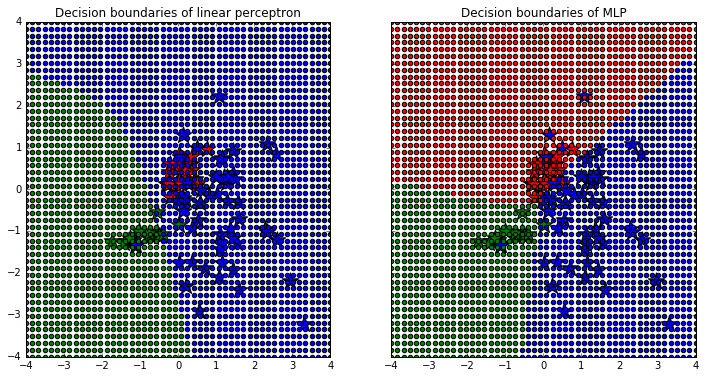

In [39]:
plt.show()